In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# sbi
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import pairplot

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

This notebook illustrates, with two simple examples, the importance of crafting your summary statistics from observations when infering model parameters with simulation-based inference (sbi). This notebook is not intended to give you a one size fits all approach. In fact it argues against this: it argues for the modelling analyst to carefully construct their summary statistics to (i) further help the analyst understand his observed data, (ii) help him understand exactly what he wants the model to recover from the observation and (iii) dramatically help the inference framework itself.

Note: all models include some noise, so same inputs to the following models give same results up to some noise.

# Example 1: The quadratic function

As parameters we simply have $a$, $b$ and $c$ for a good old classic quadratic function $y=f(x)=a\cdot x^2 + b\cdot x + c$. Given that we've observed a quadratic function defined through $a_0$, $b_0$ and $c_0$, we'd now like to recover these parameters from it's uniquely defined function values given input '$x$'.

## 1.1 prior over parameters 

First we define a prior distribution over parameters $a$, $b$ and $c$ that uniquely define a quadratic function. Here we uniformly allow $a$, $b$ and $c$ to go from $-1$ to $1$.

In [3]:
prior_min = [-1, -1, -1]
prior_max = [1, 1, 1]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## 1.2 summary statistics

Defining some helper functions first:

In [4]:
def create_x_y(params, seed=None):
    '''
    Return an x and y array for plotting based on params
    '''
    if params.ndim==1:
        params=params[np.newaxis,:]
        
    if seed is not None:
        rng=np.random.RandomState(seed)
    else:
        rng=np.random.RandomState()
    
    x=np.linspace(-1,1,200)
    xs=np.repeat(x[:,np.newaxis],params.shape[0],axis=1)
    y=params[:,0]*xs**2+params[:,1]*xs+params[:,2]+0.01*rng.randn(xs.shape[0],params.shape[0])
    return x,y

def eval(params, x, seed=None):
    '''
    Evaluate the quadratic function at 'x'
    '''
    
    if params.ndim==1:
        params=params[np.newaxis,:]
    
    if seed is not None:
        rng=np.random.RandomState(seed)
    else:
        rng=np.random.RandomState()
        
    return params[:,0]*x**2+params[:,1]*x+params[:,2]+0.01*rng.randn(1)

Let us create a truth parameter observation vector called $\theta_o=(a_o, b_o, c_o)=(0.3, -0.2, -0.1)$ and simply see what this function looks like by plotting it first.

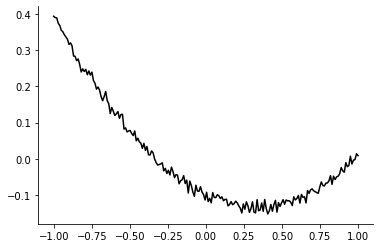

In [5]:
theta_o=np.array([0.3,-0.2,-0.1])
x,y = create_x_y(theta_o)
plt.plot(x,y, 'k')

We can think of some 'summary statistics' we can use to capture characteristics of such fuctions. The goal in the end would be to deduce the values of 'param_obs' again from literally observing such a function with defined observed characteristics (up to noise). So it's good to come up with or even $\textbf{craft}$ your summary statistics. Here's a couple of functions that, given $(a,b,c)$ values, give you such characteristics.
<br>
$\textbf{get_3_values()}$ returns 3 function evaluations at $x=-0.5, x=0$ and $x=0.75$.
<br>
$\textbf{get_MSE()}$ returns the mean squared error between true and a quadratic function corresponding to a prior distributions sample.

In [6]:
def get_3_values(theta, seed=None):
    '''
    Return 3 'y' values corresponding to x=-0.5,0,0.75 as summary statistic vector
    '''
    return np.array([eval(theta,-0.5,seed=seed), eval(theta,0,seed=seed), eval(theta,0.75,seed=seed)]).T

In [7]:
def get_MSE(theta, theta_o, seed=None):
    '''
    Return the mean-squared error (MSE) i.e. Euclidean distance from the observation function
    '''
    _, y = create_x_y(theta_o, seed=seed) # truth
    _, y_= create_x_y(theta, seed=seed) # simulations
    return np.mean(np.square(y_-y), axis=0, keepdims=True).T # MSE

Let's try a couple of samples from our prior and see their summary statistics. Notice that these indeed change in small amounts every time you rerun it due to the noise, except if you set the seed.

In [8]:
# this cell's output changes every time you run it
theta=np.array([0.2,0.2,0.3]) # a,b and c parameter values
get_3_values(np.array([0.2,0.2,0.3]))

array([[0.26468904, 0.29388637, 0.56552179]])

In [9]:
# this cell's output should never change
theta=np.array([0.2,0.2,0.3]) # a,b and c parameter values
get_3_values(np.array([0.2,0.2,0.3]), seed=10)

array([[0.26331587, 0.31331587, 0.57581587]])

In [10]:
get_MSE(theta, theta_o)

array([[0.19108815]])

In [11]:
theta=np.array([0,0.5,1]) # a,b and c parameter values
get_3_values(np.array([0.2,0.2,0.3]))

array([[0.25912506, 0.29847867, 0.55581955]])

In [12]:
get_MSE(theta, theta_o)

array([[1.17356989]])

Let's see the summary statistics of the observation itself:

In [13]:
get_MSE(theta_o, theta_o) # should be zero up to some noise

array([[0.00018626]])

In [14]:
get_3_values(theta_o)

array([[ 0.06594749, -0.10532234, -0.07327062]])

## 1.3 prior simulations

Let us see various plots of prior samples and their summary statistics versus the truth, i.e. our artificial observation.

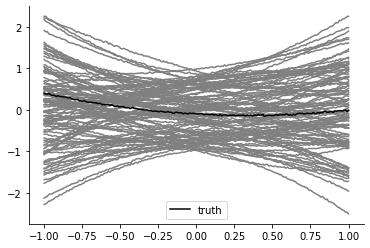

In [15]:
x, y_truth = create_x_y(theta_o)
plt.plot(x,y_truth, 'k', zorder=1, label='truth')
n_samples=100
theta = prior.sample((n_samples,))
x,y=create_x_y(theta.numpy())
plt.plot(x,y,'grey', zorder=0);
plt.legend()

In [16]:
df=pd.DataFrame(data=get_3_values(theta_o), columns=['y @ x=-0.5', 'y @ x=0', 'y @ x=0.75'], index=['truth'])
df_=pd.DataFrame(data=get_3_values(theta.numpy()), columns=['y @ x=-0.5', 'y @ x=0', 'y @ x=0.75'])
df=pd.concat([df,df_])
df.head()

,y @ x=-0.5,y @ x=0,y @ x=0.75
truth,0.078177,-0.084244,-0.062274
0,0.313430,0.625856,0.963630
1,-1.024598,-0.873986,-1.292035
2,1.496085,0.951478,0.372262
3,-1.018794,-0.682720,-1.036139


In [17]:
df=pd.DataFrame(data=get_MSE(theta_o, theta_o), columns=['MSE'], index=['truth'])
df_=pd.DataFrame(data=get_MSE(theta.numpy(), theta_o), columns=['MSE'])
df=pd.concat([df,df_])
df.head()

,MSE
truth,0.000185
0,0.526590
1,1.319771
2,1.277954
3,1.167577


So far so good right? We defined reasonable summary statistics and, a priori, there's perhaps not a reason to think one way or another might be better. When we do inference, we'd like our posterior to focus around parameter samples that have their simulated MSE very close to 0 (i.e. the truth MSE summary statistic) or their 3 extracted $(x,y)$ coordinates to be the truthful ones.

## 1.4 inference

### 1.4.1 using the MSE

Let's see if we can use the MSE to recover the true observation parameters $\theta_o=(a_0,b_0,c_0)$.

First we train a density network $q_{\phi}$ from summary statistics to model parameters with for instance masked autoregressive flows (maf's). This amounts to one round of sequential neural posterior estimation (SNPE). The parameters $\phi$ of the network are continuously adjusted during training to minimise the Kullback-Leibler divergence (KL-divergence) of the trained posterior with the true posterior.

Note: we don't actually have the true posterior, but the loss is constructed such that you can prove theoretically that minimising that loss amounts to minimising exactly that KL-divergence, which is a nice theoretical guarantee.

In [18]:
theta=prior.sample((1000,))

In [19]:
x=get_MSE(theta.numpy(), theta_o)
density_estimator_build_fun = posterior_nn(model='maf') # Pick model from ('mdn', 'maf', 'nsf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

Neural network successfully converged after 110 epochs.


Now that we've build the posterior as such, we can see how likely it finds certain parameters given that we tell it that we've observed a certain summary statistic (in this case the MSE). We can then sample from it.

In [20]:
x_o=torch.as_tensor(get_MSE(theta_o, theta_o), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)

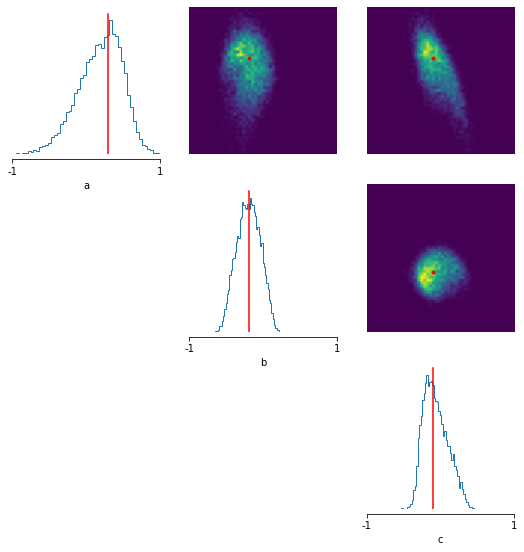

In [21]:
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

Ufff... First of all the posterior seems to pretty broad: i.e. it is not so certain about the 'true' parameters (here showcased in red). Secondly, some marginal posteriors might put quite some weight at the borders, which is definitely not what we want if the true $theta_o=(a_o, b_o, c_o)$ is not there to begin with. Let's look at very high posterior samples, i.e. the quadratic functions and see if it gets close to the truthful observation.

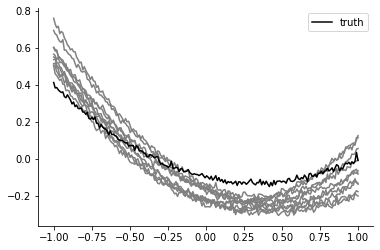

In [22]:
x_o_x,x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
# First just sample 100
theta_p=posterior.sample((100,), x=x_o)
# Find the 10 highest posterior weight samples
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

Is it absolute rubbish? No. At least all the functions are trying to get close a bit, on average. But we would expect to do better, right? Some samples really do not come so close after all. So what's going on? Do we need more samples? Feel free to try, but I'll show you in a minute that we can use the same samples with different summary statistics and do much better. Should we try a possibly more flexible density estimator like neural spline flows? Let's try.

Neural network successfully converged after 179 epochs.


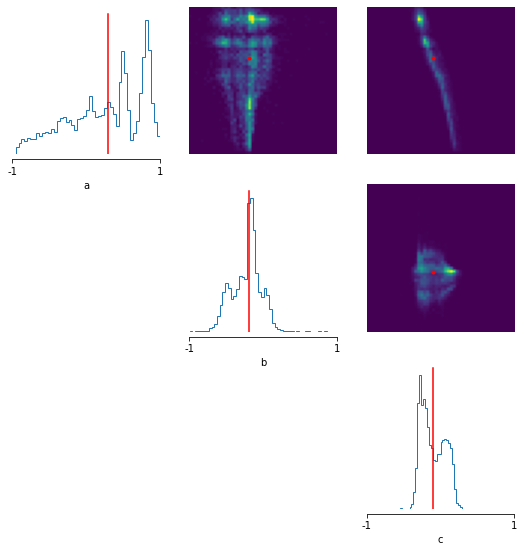

In [25]:
density_estimator_build_fun = posterior_nn(model='nsf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()
x_o=torch.as_tensor(get_MSE(theta_o, theta_o), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

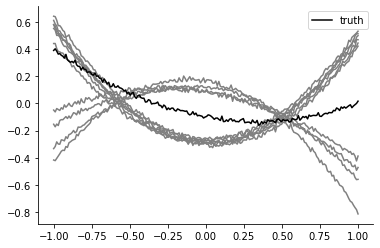

In [26]:
x_o_x,x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

Yuck... But I guess you know where we are heading. This seems to be about crafting your summary statistics after all. Soon we'll see what the $\textbf{get_3_values()}$ summary statistics vector brings us, but let's keep it to one coordinate first, used as summary statistic.

### 1.4.2 using exactly one coordinate

In [27]:
x=get_3_values(theta.numpy())[:,0][:,np.newaxis]
density_estimator_build_fun = posterior_nn(model='maf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

Neural network successfully converged after 81 epochs.


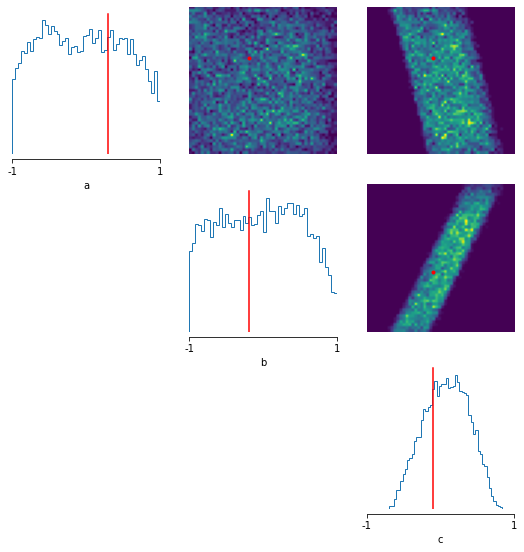

In [28]:
x_o=torch.as_tensor(get_3_values(theta_o)[:,0][:,np.newaxis], dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

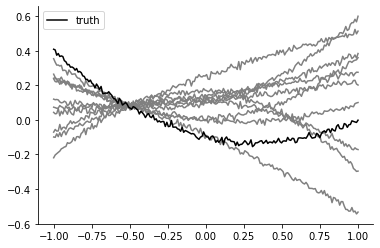

In [29]:
x_o_x,x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

Still bad... But the posterior makes a lot of sense. Since we asked to recover one specific coordinate, that's exactly what we got: just introducing one coordinate can obviously be fitted by many different quadratic functions, so the posterior is right to be broad :) . So the MSE wasn't good, but might have been not good for a different reason (we'll come back to this). Just one coordinate is also not good, for more obvious reasons. But, since 3 coordinates uniquely define a quadratic function, why not use 3? Indeed.

### 1.4.3 using 3 coordinates

In [30]:
x=get_3_values(theta.numpy())
density_estimator_build_fun = posterior_nn(model='maf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

Neural network successfully converged after 145 epochs.


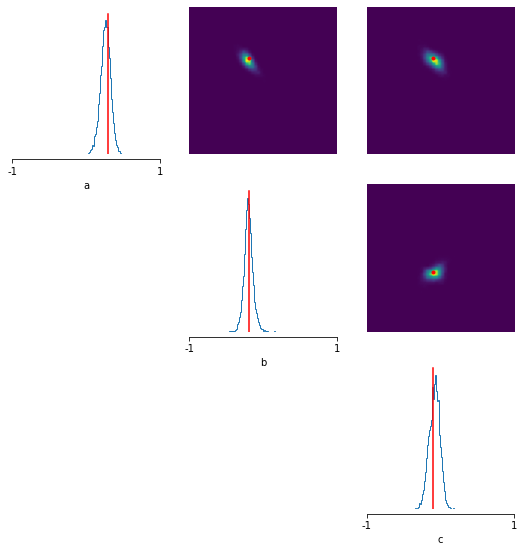

In [31]:
x_o=torch.as_tensor(get_3_values(theta_o), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

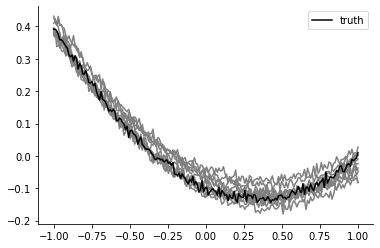

In [32]:
x_o_x, x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

Ok this definitely seems to work! The posterior correctly focuses on the true parameters with greater confidence. You can experiment yourself how this improves further with more training samples or you could try to see how many you'd exactly need to keep having a satisfyingly looking posterior and high posterior sample simulations. But a last thing we ought to check: can we use 2 coordinates and the MSE? Would this make things better or worse? Why?

### 1.4.4 using 2 coordinates and the MSE

In [33]:
x=np.concatenate((get_3_values(theta.numpy())[:,:2], get_MSE(theta.numpy(),theta_o)), axis=1)
density_estimator_build_fun = posterior_nn(model='maf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

Neural network successfully converged after 99 epochs.


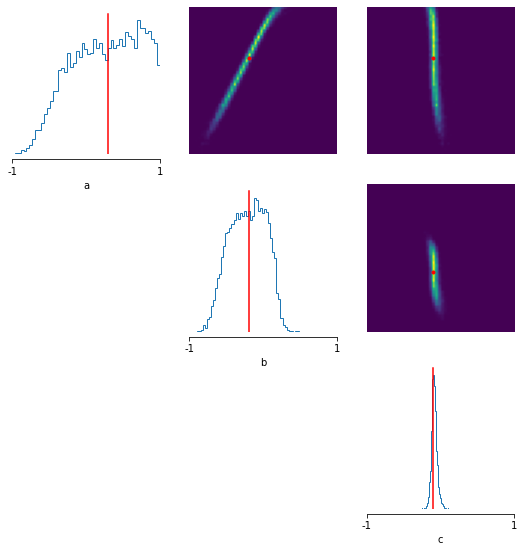

In [34]:
x_o=torch.as_tensor(np.concatenate((get_3_values(theta_o)[:,:2], get_MSE(theta_o, theta_o)), axis=1), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

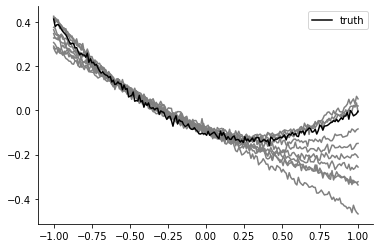

In [35]:
x_o_x, x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

Again a mess! As expected, two coordinates are recovered well but the MSE does not help to further reduce the distance with the true quadratic function. In fact, what happens if we use the MSE on top of the 3 coordinates?

### 1.4.5 using 3 coordinates and the MSE

In [36]:
x=np.concatenate((get_3_values(theta.numpy()), get_MSE(theta.numpy(), theta_o)), axis=1)
density_estimator_build_fun = posterior_nn(model='maf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

Neural network successfully converged after 98 epochs.


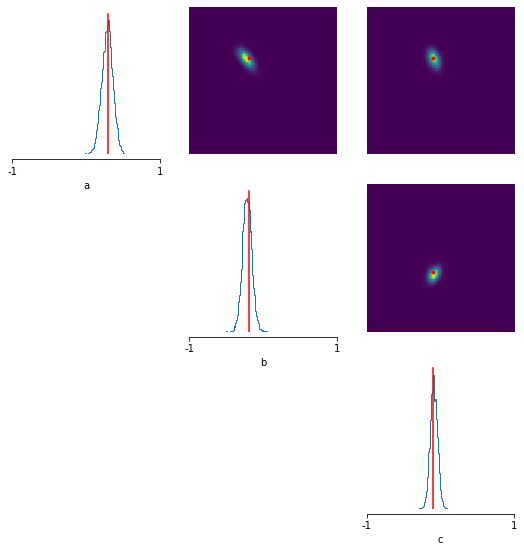

In [37]:
x_o=torch.as_tensor(np.concatenate((get_3_values(theta_o), get_MSE(theta_o, theta_o)), axis=1), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=['a','b','c'],
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

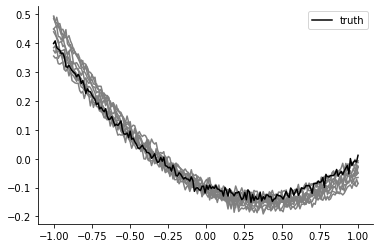

In [38]:
x_o_x, x_o_y = create_x_y(theta_o)
plt.plot(x_o_x,x_o_y, 'k', zorder=1, label='truth')
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x,x_y=create_x_y(theta_p_considered.numpy())
plt.plot(x_x,x_y,'grey', zorder=0);
plt.legend()

It seems like, whether we add it or not, it doesn't really make a 'big' difference. So what's up with the MSE? Why does it not seem so informative to constrain the posterior? In 1.5, we'll see both the power and pitfalls of summary statistics.

## 1.5 Prior simulations' summary statistics vs observed summary statistics

Now to understand this.. Let's look at a histogram of the four summary statistics we've experimented with of our prior simulations, and see how they compare to our observed truth summary statistic vector:

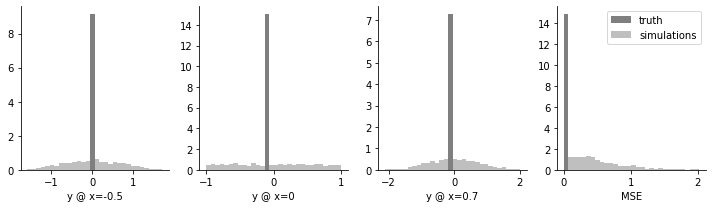

In [39]:
stats=np.concatenate((get_3_values(theta.numpy()), get_MSE(theta.numpy(), theta_o)), axis=1)
x_o=np.concatenate((get_3_values(theta_o), get_MSE(theta_o, theta_o)), axis=1)
features=['y @ x=-0.5', 'y @ x=0', 'y @ x=0.7', 'MSE']
fig, axes = plt.subplots(1, 4, figsize = (10, 3))
xlabelfontsize=10
for i, ax in enumerate(axes.reshape(-1)):
    ax.hist([x[:,i], x_o[:,i]], \
            color=['grey', 'black'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
            label=['simulations', 'truth'])
    ax.set_xlabel(features[i], fontsize=xlabelfontsize)
    if i==3:
        ax.legend()
plt.tight_layout()

We see that for the coordinates, simulations cover the truthful observation. That is: it covers it from the left and right side in each case. For the MSE, simulations can never actually cover the observation (at 0, up to noise) since no prior simulation (unless you get extremely lucky) will have exactly an MSE of 0 (feel free to zoom in and check). So the network, if you'd include the MSE, will never see a 0 true value for the MSE in its training data. As such, after training, when you condition on the observed summary statistic, you'd ask the inference to come up with a posterior for a summary statistic vector it has never seen during training!

**Conclusion:**
To craft your own summary stastistics for your own kind of observations might seem laborious work in the beginning... ...and it probably is. But, especially for raw experimental data (not artificially created) it will be very worthwile to incorporate all your knowledge into it. It makes sense to carefully observe your experimentally observed trace e.g. and think of meaningful characteristics you could capture from it. You'll convice yourself, first of all, that you understand the data you're working with (that's a surplus), but additionally, you know exactly what kind of features your network should capture and finally (last but not least), you'll dramatically improve the inference itself. 

# Example 2: a hyperpolarization trace 

Ok, now let's apply what we've learnt. Let's assume the experimentalist injected some negative current in some cortical neuron of some animal and now, as a modeller, we'd like to recover that with a simple passive Hodgkin-Huxley model. The model allows to inject the same current into it that the experimentalist used and can, based on its parameters (the capacitance $C$, the leak conductance $g_{leak}$ and the leak potential $E_{leak}$), output a membrane voltage trace that, you'd like, is close to what the experimentalist has seen. That requires tuning its parameters and thus fits our inference framework.

## 2.1 prior over parameters 

Parameters have the following prior defined uniform range:

In [40]:
# 3 parameters
label_params = ['$C$', r'$g_{leak}$', r'$E_{leak}$']

In [41]:
prior_min = [0.5, 1e-3, -100]
prior_max = [1.5, 1e-1, -75]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## 2.2 simulator

First we define our complete simulator with a couple of functions. This time the noise is not simply added to the output of the simulator but added to the input (the current).

In [42]:
# First we'll set up some hyperparameters (time of the onset and offset of current stimulation,
# amount of current injected, time step, ...)
def syn_current(duration=800, dt=0.04, t_on = 100, curr_level = -1e-1,  seed=None):
    
    if seed is not None:
        rng=np.random.RandomState(seed)
    else:
        rng=np.random.RandomState()
        
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration+dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = curr_level # muA
    I+=0.01*rng.randn(I.shape[0])
    return I, t_on, t_off, dt, t

In [43]:
# Passive simulator
def pass_HH_simulator(theta, dt, t, I):
    """Simulates the passive response for a specified time duration and current

        Parameters
        ----------
        theta : np.array
            Parameters matrix
        dt : float
            Timestep
        t : array
            Numpy array with the time steps
        I : array
            Numpy array with the input current
        """

    if theta.ndim==1:
        theta=theta[np.newaxis,:]
        
    voltage=np.zeros((theta.shape[0],I.shape[0]))
    for num, param in enumerate(theta):
        C = param[0]  # uF
        C.astype(float)
        g_leak = param[1] # mS
        g_leak.astype(float)
        E_leak = param[2]  # mV
        E_leak.astype(float)

        tstep = float(dt)

        ####################################
        # simulation from initial point
        V = np.zeros_like(t)  # voltage
        V[0] = E_leak # initial voltage, here set to E_leak mV

        for i in range(1, t.shape[0]):
            tau_V_inv = (g_leak) / C
            V_inf = (g_leak * E_leak
                + I[i - 1] / (tstep ** 0.5)
            ) / (tau_V_inv * C)
            V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
            
        voltage[num,:]=V
    
    return voltage

In [44]:
def run_model(theta, seed=None):
    
    # input current, time step
    I, t_on, t_off, dt, t = syn_current(seed=seed)

    t = np.arange(0, len(I), 1)*dt
   
    states = pass_HH_simulator(theta, dt, t, I)

    return dict(data=states, time=t, dt=dt, I=I)

## 2.3 summary statistics

We use what we've learnt in the 1st chapter and craft our summary statistics. Because it's a hyperpolarization trace, it would make sense to construct a couple of averages of the membrane voltages over some time intervals. The observed truthfull ones should be well covered by simulations from the prior. The membrane voltage will also show a typical exponential decline right after onset. So one could wonder whether the time constant of an exponential fit through this phase wouldn't make for an interesting summary statistic. 

In [45]:
from scipy.optimize import curve_fit

In [46]:
def exponential(x, a, k, b, u):
    return a*np.exp(-k*(x-u)) + b

In [47]:
def summary_statistics(x):
    """Calculate summary statistics for a passive current stimulation experiment.

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """

    t = x["time"]
    dt = x["dt"]
    
    sum_stats=[]
    for v in x['data']:
        # 1. Exponential fit, the time constant
        exp_params_init=[10, 0.1, v[17000], 100]
        best_exp_params, _ = curve_fit(exponential, t[2500:17000], v[2500:17000], p0=exp_params_init)
        tau=1/best_exp_params[1]
        
        # 2. The steady state (SS), i.e. the mean of the membrane voltage at the end of the current
        #    stimulation window
        SS = np.mean(v[15000:17500])

        # 3. The mean voltage, i.e. the mean of the voltage during the current stimulation window
        v_mean = np.mean(v[2500:17500])

        # concatenation of summary statistics
        sum_stats_vec = np.array([tau, SS, v_mean])
        sum_stats.append(sum_stats_vec)
        
    return np.array(sum_stats)

In [48]:
def simulation_wrapper(theta, seed=None):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_model(theta, seed=seed)
    summstats = torch.as_tensor(summary_statistics(obs))
    return summstats

Let us make a truthful 'experimental' observation (up to some noise) with $\theta_o=(C_o,g_{leak,o},E_{leak,o})=(1,0.05,-80)$.

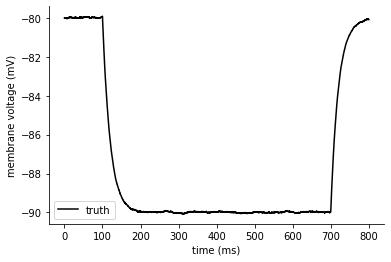

In [49]:
theta_o=np.array([1,5e-2,-80])
observation=run_model(theta_o)
plt.plot(observation['time'], observation['data'][0,:], 'k', label='truth')
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.legend()

And let us compare its summary stastistics to randomly generated prior simulations' summary statistics. Sometimes curve_fit will throw warnings. You can ignore these throughout the rest of this notebook.

In [50]:
df=pd.DataFrame(data=simulation_wrapper(theta_o).numpy(),
                columns=['tau', 'steady state', 'mean voltage'],
                index=['truth'])
theta=prior.sample((3,))
df_=pd.DataFrame(data=simulation_wrapper(theta.numpy()).numpy(), 
                 columns=['tau', 'steady state', 'mean voltage'])
df=pd.concat([df,df_])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


,tau,steady state,mean voltage
truth,20.096014,-90.016508,-89.682297
0,92.044345,-124.428470,-117.750350
1,18.035652,-86.658067,-86.448568
2,11.964366,-87.227187,-87.113774


We can check whether the curve fittig works well by trying random samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


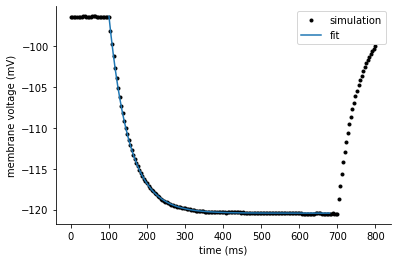

In [51]:
theta=prior.sample((1,))
x_x=run_model(theta.numpy())
plt.plot(x_x['time'][::100], x_x['data'][0,::100], 'k.', label='simulation')
popt, _  = curve_fit(exponential,
                     x_x['time'][2500:17000],
                     x_x['data'][0, 2500:17000],
                     p0=[10,0.1,x_x['data'][0,17000],100])
plt.plot(x_x['time'][2500:17000], exponential(x_x['time'][2500:17000], *popt), label='fit')
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.legend()

## 2.4 inference

Let's do inference, analogously as before.

In [52]:
theta=prior.sample((1000,))
x=simulation_wrapper(theta.numpy())
density_estimator_build_fun = posterior_nn(model='maf')
inference = SNPE(
    prior, 
    density_estimator=density_estimator_build_fun
)
_ = inference.append_simulations(
                         torch.as_tensor(theta, dtype=torch.float32),
                         torch.as_tensor(x, dtype=torch.float32)
                        ).train()
posterior = inference.build_posterior()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Neural network successfully converged after 113 epochs.


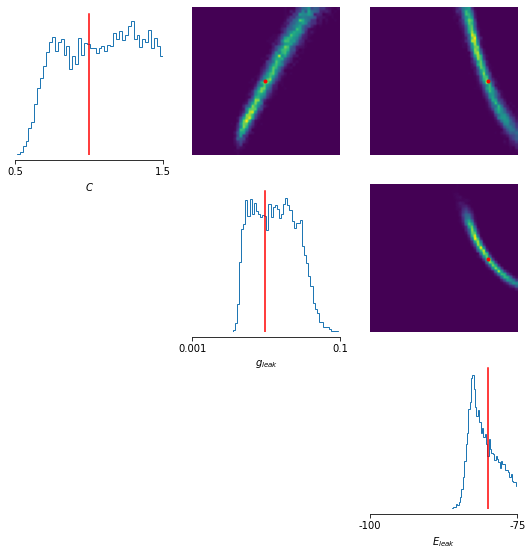

In [53]:
x_o=torch.as_tensor(simulation_wrapper(theta_o), dtype=float)
theta_p=posterior.sample((10000,), x=x_o)
fig, axes = pairplot(theta_p,
                       limits=list(zip(prior_min,prior_max)),
                       ticks=list(zip(prior_min,prior_max)),
                       figsize=(9,9),
                       labels=label_params,
                       points_offdiag={'markersize': 6},
                       points_colors='r',
                       points=theta_o);

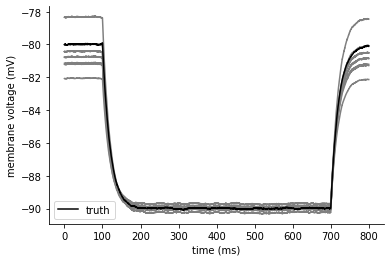

In [54]:
plt.plot(observation['time'], observation['data'][0,:], 'k', label='truth', zorder=1)
theta_p=posterior.sample((100,), x=x_o)
ind_10_highest=np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered=theta_p[ind_10_highest,:]
x_x=run_model(theta_p_considered.numpy())
plt.plot(x_x['time'], x_x['data'].T, c='grey', zorder=0)
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.legend()

So the posterior is not so constrained, shows correlation accross variables (!) and leaves some uncertainty. In addition our high posterior sample simulations only look good for the time window when we apply current. Do you know why? One who has carefully observed the summary statistics, might know why. We only calculate them exactly for times within our current stimulation window! It is left as an exercise for the reader to update the summary statistics to capture features also outside the simutation window and consequentially see the posterior and high posterior sample simulations change. Good luck!